# Using the parameters update functionality 
Now that a the execution examples have been covered, let's dive into the functionalities that CUNQA provides. The one treated in this note is the **parameters update**. 

There are several quantum-classical algorithms that require many executions of the same circuit but changing the value of its parameters, optimized with a classical algorithm. In order to optimize this, CUNQA users can upgrade the circuit parameters with no need to resend the circuit, i.e., **sending to the vQPUs ONLY the new parameters**. This reduces the total amout of data sent to the vQPUs. In this notebook, the same example is going to be implemented twice: first without using the parameter update functionality and, then, using it. This way both workflows can be easily compared. 

Let´s see how to work with this feature taking as an example a _Variational Quantum Algorithm_ for state preparation. To start, all the imports are done and the vQPUs turned ON. After this, the `get_QPUs()` function is called to obtain the `QPU` instance related with the raised vQPU. Note that **only one vQPU is raised**. And this is because here the parallelization is not the pursued goal, but to see how the parameter update functionality works and change the execution. 

In [1]:
import os, sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from scipy.stats import entropy, norm
from scipy.optimize import minimize

sys.path.append(os.getenv("HOME"))

from cunqa import get_QPUs, qraise, qdrop
from cunqa.qpu import run

family = qraise(1, "00:20:00", simulator = "Aer",  co_located = True)
[qpu] = get_QPUs(co_located=True, family = family)

print(f"\nQPU properties: \n\t id: {qpu.id}, backend: {qpu.backend.name}, simulator: {qpu.backend.simulator}, version: {qpu.backend.version}.")

Requested QPUs with command:
	qraise -n 1 -t 00:20:00 --simulator=Aer --co-located
QPUs ready to work ✅

QPU properties: 
	 id: 299553_506580_299553, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.


Now, a _Hardware Efficient Ansatz_ is employed to build the parametrized circuit. Even though a general function is defined, the ansatz employed in this case has 6 qubits and 3 layers.

In [2]:
def hardware_efficient_ansatz(num_qubits, num_layers):
    qc = QuantumCircuit(num_qubits)
    param_idx = 0
    for _ in range(num_layers):
        for qubit in range(num_qubits):
            phi = Parameter(f'phi_{param_idx}_{qubit}')
            lam = Parameter(f'lam_{param_idx}_{qubit}')
            qc.ry(phi, qubit)
            qc.rz(lam, qubit)
        param_idx += 1
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)
    qc.measure_all()
    return qc

num_qubits = 6
num_layers = 3
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

As usual in optimization jobs, a cost function must be defined. But, in this case, the goal is to measure how far the solution is from a target distribution. So, before defining the cost function, the target distribution and the measure of distribution divergence must be defined.

In the case of the target distribution, the chosen one corresponds to a **normal distribution** among all the $2^n$ possible outcomes of the circuit. In case of the measure, the **Kullback-Leibler divergence** is employed.

In [3]:
def target_distribution(num_qubits):
    # Define a normal distribution over the states
    num_states = 2 ** num_qubits
    states = np.arange(num_states)
    mean = num_states / 2
    std_dev = num_states / 4
    target_probs = norm.pdf(states, mean, std_dev)
    target_probs /= target_probs.sum()  # Normalize to make it a valid probability distribution
    target_dist = {format(i, f'0{num_qubits}b'): target_probs[i] for i in range(num_states)}
    return target_dist

def KL_divergence(counts, n_shots, target_dist):
    # Convert counts to probabilities
    pdf = pd.DataFrame.from_dict(counts, orient="index").reset_index()
    pdf.rename(columns={"index": "state", 0: "counts"}, inplace=True)
    pdf["probability"] = pdf["counts"] / n_shots
    
    # Create a dictionary for the obtained distribution
    obtained_dist = pdf.set_index("state")["probability"].to_dict()
    
    # Ensure all states are present in the obtained distribution
    for state in target_dist:
        if state not in obtained_dist:
            obtained_dist[state] = 0.0
    
    # Convert distributions to lists for KL divergence calculation
    target_probs = [target_dist[state] for state in sorted(target_dist)]
    obtained_probs = [obtained_dist[state] for state in sorted(obtained_dist)]
    
    # Calculate KL divergence
    kl_divergence = entropy(obtained_probs, target_probs)
    
    return kl_divergence

Finally, because both cases (the one that does not use the feature and the one which does) need a equivalent callback function, a function that produces a new one each time is called is implemented. This is done to simply the readability of the code.

In [4]:
def make_callback(cost_function):
    i = 0
    cost = []
    individuals = []

    pbar = tqdm(desc="Optimization", unit="iter")

    def callback(xk):
        nonlocal i

        e = cost_function(xk)
        individuals.append(xk)
        cost.append(e)

        pbar.update(1)
        pbar.set_postfix(fx=f"{e:.3e}")
        i += 1

    def close():
        pbar.close()

    return callback, close, cost

## No parameter update feature

First, as the basis case the normal execution method will be employed, i.e., upgrading the parameters and sending the whole circuit to the QPU. For this purpose, the cost function defined is the following.

In [5]:
def cost_function_run(params):
    target_dist = target_distribution(num_qubits)
    
    circuit = ansatz.assign_parameters(params)
    result = run(circuit, qpu, shots = 1e5).result
    counts = result.counts
    
    return KL_divergence(counts, 1e5, target_dist)

This cost function updates the parameters given by the optimizer, asigns them to the ansatz and sends the circuit to the vQPU. Now everything is in place to perform the optimization:

In [6]:
callback_run, close_run, cost_run = make_callback(cost_function_run)

optimization_result_run = minimize(fun = cost_function_run, 
                                   x0 = np.zeros(ansatz.num_parameters), 
                                   method = 'COBYLA',
                                   callback = callback_run, 
                                   tol = 0.01,
                                   options = {'maxiter': 4000}
                                  )
close_run()

Optimization: 643iter [01:38,  6.56iter/s, fx=1.492e-02]


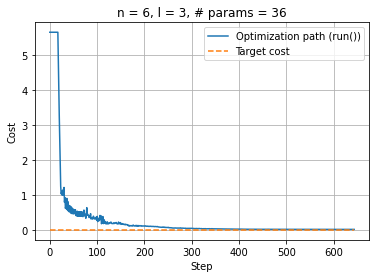

In [7]:
%matplotlib inline
plt.clf()
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = optimization_result_run.nfev
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost")
plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {ansatz.num_parameters}")
plt.grid(True)
plt.show()

## Using the parameters update feature

The first step now is to create the `qjob.QJob` object by calling the `run` function. This step, that was not necessary in the previous case, is needed now because the circuit needs to be sent before the optimization begins to have it stored in the vQPU.

In [8]:
circuit = ansatz.assign_parameters(np.zeros(ansatz.num_parameters))
qjob = run(circuit, qpu, shots = 1e5)

After doing this, the optimization with the parameters update feature can be performed. To do it a cost function must be defined, just as in the previous case. The difference lies in its content, as now, instead of calling the `run` method, the `QJob.upgrade_parameters()` method is called. This method works because the vQPUs automatically detect that the circuit sent is parametrized and store them in case its parameters may come.

**Important considerations:**
- The method acepts parameters in a `list`, if you have a `numpy.array`, simply apply `.tolist()` to transform it.
- The `qjob.QJob.upgrade_parameters()` is a non-blocking call, as it was `qpu.QPU.run()`.

In [9]:
def cost_function_update(params):
    target_dist = target_distribution(num_qubits)
    
    qjob.upgrade_parameters(params.tolist())
    counts = qjob.result.counts
    
    return KL_divergence(counts, 1e5, target_dist)

Now we are ready to start our optimization. We will use `scipy.optimize` to minimize the divergence of our result distribution from the target one:

In [10]:
callback_update, close_update, cost_update = make_callback(cost_function_update)

optimization_result_update = minimize(cost_function_update, 
                               x0 =  np.zeros(ansatz.num_parameters), 
                               method = 'COBYLA',
                               callback = callback_update, 
                               tol = 0.01,
                               options={'maxiter': 4000}
                               )
close_update()

Optimization: 1063iter [02:39,  6.67iter/s, fx=1.588e-02]


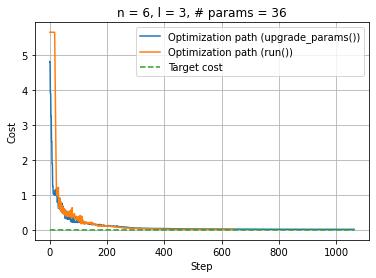

In [11]:
%matplotlib inline
plt.clf()
plt.plot(np.linspace(0, optimization_result_update.nfev, optimization_result_update.nfev), cost_update, label="Optimization path (upgrade_params())")
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = max(optimization_result_run.nfev, optimization_result_update.nfev)
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost")
plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {ansatz.num_parameters}")
plt.grid(True)
plt.show()

And, as usual when using the `qraise()` function in Python, the `qdrop()` function can be used to remove the vQPUs.

In [12]:
qdrop(family)

Removed job(s) with ID(s): 299553 
